### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Матюшкин Денис Владимирович
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант № 10

Текст задания:

1. Набор данных rock_paper_scissors

2. Классы с метками 1,0,2

3. Требования к архитектуре сети MLP:

- Кол-во скрытых слоев 4

- Кол-во нейронов 60 в каждом нечетном скрытом слое, 80 в каждом четном скрытом слое

- Оптимизатор Adafactor

- Функция активации в скрытых слоях selu

- Регуляризация L1 в каждом четном скрытом слое

4. Требования к архитектуре сети CNN:

- Кол-во сверточных слоев 4

- Количество фильтров в сверточных слоях 16

- Размеры фильтра 4х4

- Оптимизатор Adamax

- Функция активации в сверточных слоях elu

- Функция активации в скрытых плотных слоях tanh

- Слои dropout после каждого скрытого плотного слоя

5. Показатель качества бинарной классификации:

- индекс Rand, равный (TP + TN)/(TP + TN + FP + FN)

6. Показатель качества многоклассовой классификации:

- минимальная полнота классов, где полнота (recall) класса равна доле правильных предсказаний для всех точек, принадлежащих этому классу.

### Решение:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from PIL import Image, ImageOps

In [2]:
ds = tfds.load("rock_paper_scissors", split=['train','test'])
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])

df_train.shape, df_test.shape

((2520, 2), (372, 2))

In [ ]:
df_train.head()

,image,label
0,"[[[254, 254, 254], [253, 253, 253], [254, 254,...",2
1,"[[[254, 254, 254], [253, 253, 253], [254, 254,...",2
2,"[[[254, 254, 254], [253, 253, 253], [254, 254,...",0
3,"[[[253, 253, 253], [253, 253, 253], [254, 254,...",1
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


2. Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.

In [ ]:
def plot_random_sample(images, n = 10, num_row = 2, num_col = 5):
    imgs = random.sample(list(images), n)
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    for i in range(num_row * num_col):
        img = imgs[i]
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

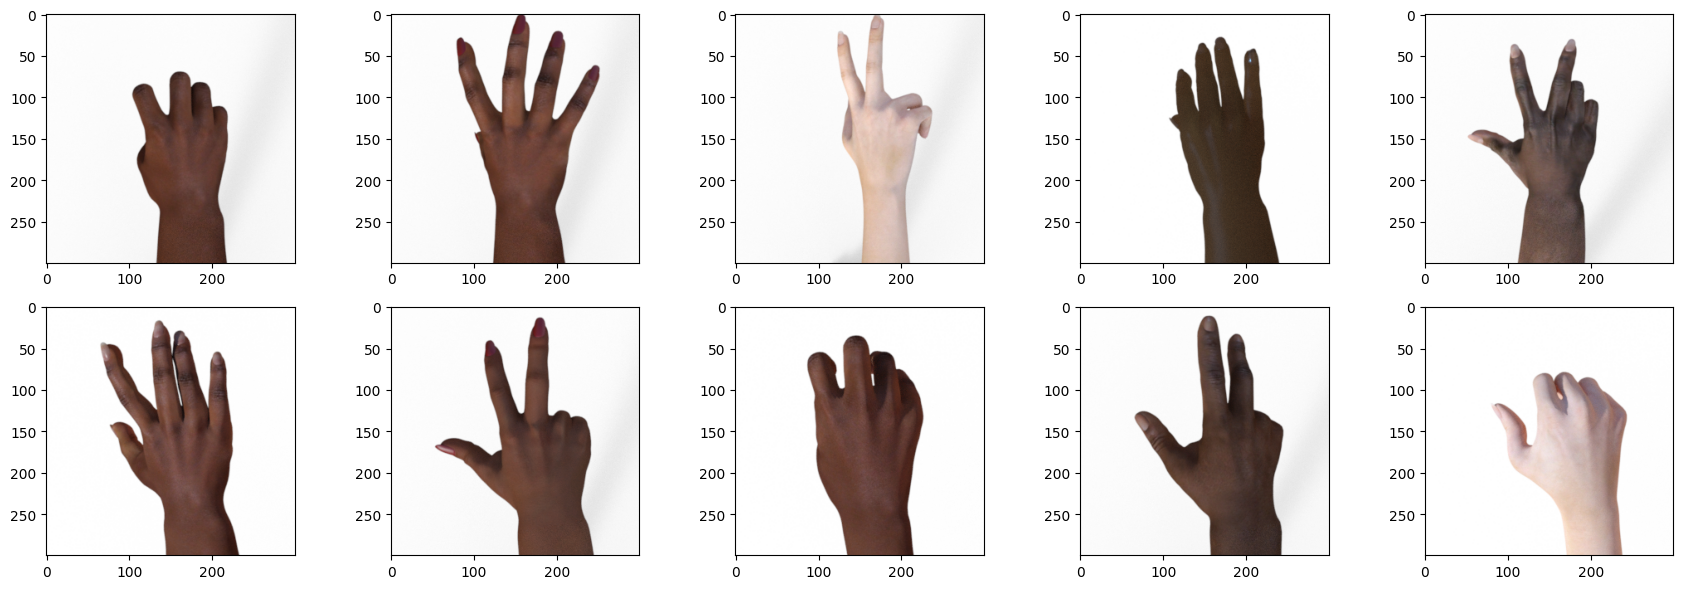

In [ ]:
plot_random_sample(df_train['image'])

3. Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми. Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании). Отследите обучение нейронных сетей и укажите, на сколько процентов снизились в результате обучения потери по отношению к потерям на первой эпохе обучения. Оцените результаты обучения нейронных сетей (варианты: нейронная сеть обучилась, недообучилась, переобучилась).

In [6]:
df_train_binary = df_train[df_train['label'].isin([1, 0])]
df_test_binary = df_test[df_test['label'].isin([1, 0])]
df_train_binary.shape, df_test_binary.shape

((1680, 2), (248, 2))

In [7]:
df_train_binary['label'].unique(), df_test_binary['label'].unique()

(array([0, 1]), array([1, 0]))

In [8]:
df_train_binary.iloc[0]['image'].shape

(300, 300, 3)

In [9]:
train_binary_labels = df_train_binary['label'].to_numpy(dtype=np.float32)
test_binary_labels = df_test_binary['label'].to_numpy(dtype=np.float32)
train_binary_labels.shape, test_binary_labels.shape

((1680,), (248,))

In [11]:
train_binary_images = np.zeros(shape=(df_train_binary.shape[0],300,300,3), dtype=np.float32)
test_binary_images  = np.zeros(shape=(df_test_binary.shape[0],300,300,3), dtype=np.float32)
train_binary_images.shape, test_binary_images.shape

((1680, 300, 300, 3), (248, 300, 300, 3))

In [12]:
for idx in range(train_binary_labels.shape[0]):
    train_binary_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train_binary.iloc[idx]['image']))

for idx in range(test_binary_labels.shape[0]):
    test_binary_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test_binary.iloc[idx]['image']))

train_binary_images.shape, test_binary_images.shape

((1680, 300, 300, 3), (248, 300, 300, 3))

In [13]:
train_binary_images /= 255
test_binary_images  /= 255

train_binary_images.shape, test_binary_images.shape

((1680, 300, 300, 3), (248, 300, 300, 3))

Обучим нейронную сеть MLP по задаче бинарной классификации изображений:

In [14]:
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(60, activation='selu'),
    tf.keras.layers.Dense(80, activation='selu', kernel_regularizer=tf.keras.regularizers.L1(l1=0.01)),
    tf.keras.layers.Dense(60, activation='selu'),
    tf.keras.layers.Dense(80, activation='selu', kernel_regularizer=tf.keras.regularizers.L1(l1=0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_mlp.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adafactor(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_mlp = model_mlp.fit(
    train_binary_images,
    train_binary_labels,
    epochs=10,
    batch_size=64,
    validation_data=(test_binary_images, test_binary_labels)
)

Epoch 1/10
27/27 [==============================] - 24s 800ms/step - loss: 10.4702 - accuracy: 0.5774 - val_loss: 10.5113 - val_accuracy: 0.5000
Epoch 2/10
27/27 [==============================] - 27s 985ms/step - loss: 10.2197 - accuracy: 0.6315 - val_loss: 10.4052 - val_accuracy: 0.5000
Epoch 3/10
27/27 [==============================] - 17s 616ms/step - loss: 10.0216 - accuracy: 0.6470 - val_loss: 10.1055 - val_accuracy: 0.4919
Epoch 4/10
27/27 [==============================] - 22s 825ms/step - loss: 9.8625 - accuracy: 0.6685 - val_loss: 9.8961 - val_accuracy: 0.5565
Epoch 5/10
27/27 [==============================] - 18s 659ms/step - loss: 9.6721 - accuracy: 0.7155 - val_loss: 9.9537 - val_accuracy: 0.5202
Epoch 6/10
27/27 [==============================] - 16s 597ms/step - loss: 9.4980 - accuracy: 0.7357 - val_loss: 9.7499 - val_accuracy: 0.5000
Epoch 7/10
27/27 [==============================] - 15s 570ms/step - loss: 9.3861 - accuracy: 0.7030 - val_loss: 9.6600 - val_accuracy: 

Обучим нейронную сеть CNN по задаче бинарной классификации изображений:

In [17]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_cnn = model_cnn.fit(
    train_binary_images,
    train_binary_labels,
    epochs=10,
    batch_size=64,
    validation_data=(test_binary_images, test_binary_labels)
)


Epoch 1/10
27/27 [==============================] - 179s 6s/step - loss: 0.8347 - accuracy: 0.6369 - val_loss: 0.5853 - val_accuracy: 0.6774
Epoch 2/10
27/27 [==============================] - 165s 6s/step - loss: 0.3265 - accuracy: 0.9095 - val_loss: 0.4223 - val_accuracy: 0.7944
Epoch 3/10
27/27 [==============================] - 165s 6s/step - loss: 0.1797 - accuracy: 0.9482 - val_loss: 0.3336 - val_accuracy: 0.8347
Epoch 4/10
27/27 [==============================] - 163s 6s/step - loss: 0.1089 - accuracy: 0.9708 - val_loss: 0.2447 - val_accuracy: 0.8710
Epoch 5/10
27/27 [==============================] - 163s 6s/step - loss: 0.0658 - accuracy: 0.9815 - val_loss: 0.1684 - val_accuracy: 0.9153
Epoch 6/10
27/27 [==============================] - 186s 7s/step - loss: 0.0474 - accuracy: 0.9869 - val_loss: 0.1379 - val_accuracy: 0.9395
Epoch 7/10
27/27 [==============================] - 206s 8s/step - loss: 0.0347 - accuracy: 0.9923 - val_loss: 0.2264 - val_accuracy: 0.8669
Epoch 8/10
27

4. Постройте кривые обучения нейронных сетей бинарной классификации для показателей потерь и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

In [3]:
from matplotlib import rcParams

In [4]:
def plot_training_loss(history, epochs, name):
    rcParams['figure.figsize'] = (10, 6)
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False

    plt.plot(np.arange(1, epochs + 1), history.history['loss'], label=f'{name} Training Loss')
    plt.plot(np.arange(1, epochs + 1), history.history['val_loss'], label=f'{name} Validation Loss')

    plt.title(f'Training vs. Validation Loss {name}', size=20)
    plt.xlabel('Epoch', size=14)
    plt.ylabel('Loss', size=14)
    plt.legend()
    plt.show()

In [5]:
def plot_training_accuracy(history, epochs, name):
    rcParams['figure.figsize'] = (10, 6)
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False

    plt.plot(np.arange(1, epochs + 1), history.history['accuracy'], label=f'{name} Training Accuracy')
    plt.plot(np.arange(1, epochs + 1), history.history['val_accuracy'], label=f'{name} Validation Accuracy')

    plt.title(f'Training vs. Validation Accuracy {name}', size=20)
    plt.xlabel('Epoch', size=14)
    plt.ylabel('Accuracy', size=14)
    plt.legend()
    plt.show()

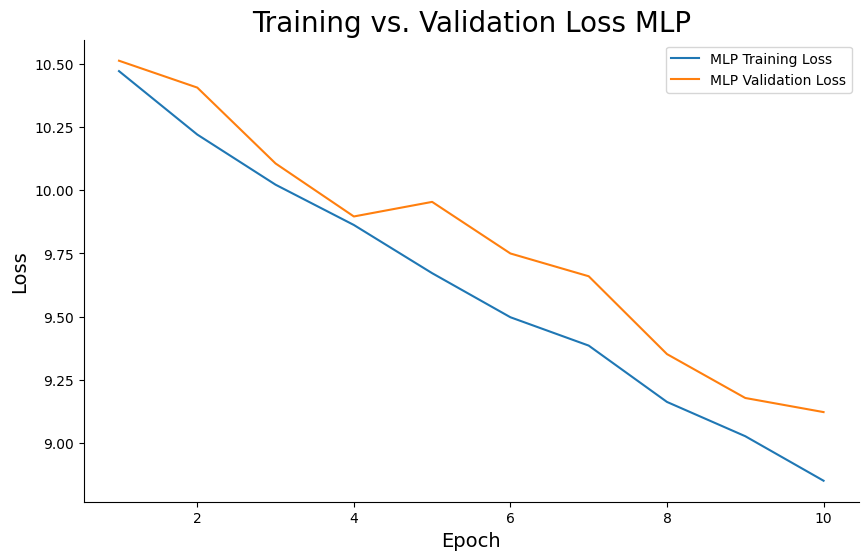

In [15]:
plot_training_loss(history_mlp, 10, "MLP")

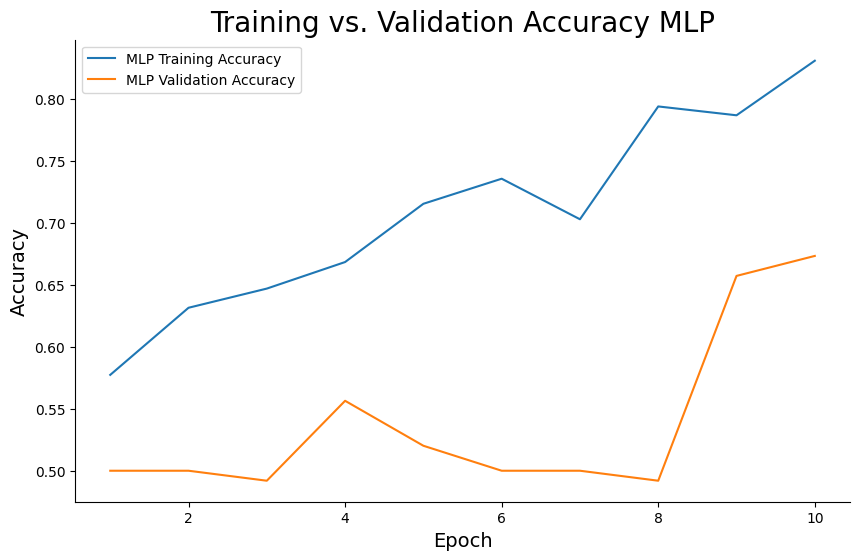

In [16]:
plot_training_accuracy(history_mlp, 10, "MLP")

По графикам можно сказать, что сеть недообучилась.

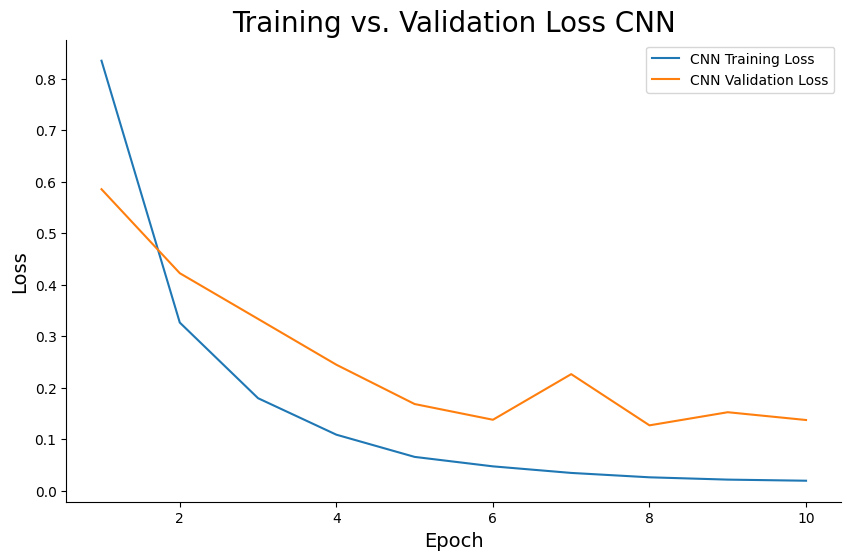

In [18]:
plot_training_loss(history_cnn, 10, "CNN")

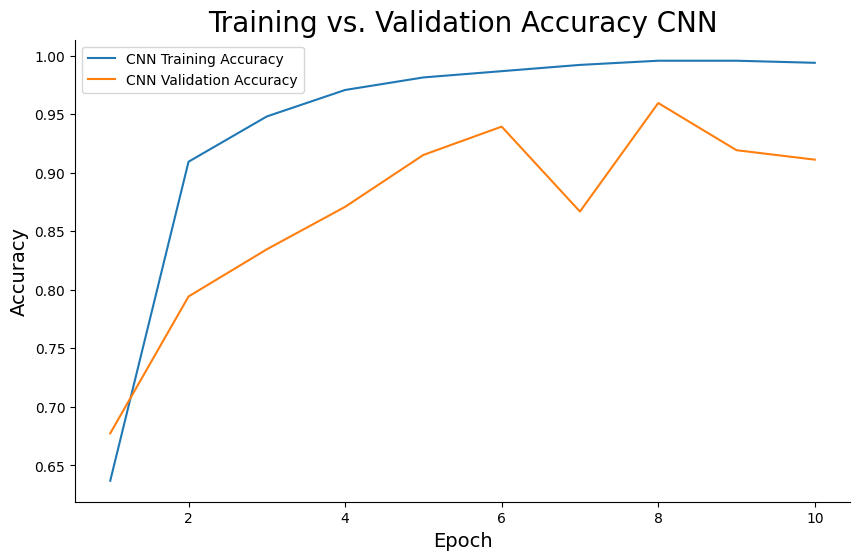

In [19]:
plot_training_accuracy(history_cnn, 10, "CNN")

По графикам можно сказать, что сеть недообучилась.

In [20]:
def percentage_loss_reduction(history):
  initial_loss = history.history['loss'][0]
  final_loss = history.history['loss'][-1]
  loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100

  return loss_reduction

In [21]:
loss_reduction_mlp = percentage_loss_reduction(history_mlp)
loss_reduction_cnn = percentage_loss_reduction(history_cnn)

print("Процент снижения потерь для MLP модели: {:.2f}%".format(loss_reduction_mlp))
print("Процент снижения потерь для CNN модели: {:.2f}%".format(loss_reduction_cnn))

Процент снижения потерь для MLP модели: 15.45%
Процент снижения потерь для CNN модели: 97.66%


5. Сравните качество бинарной классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

In [6]:
def Rand(predictions, y_true):
    TP = np.sum((predictions == 1) & (y_true == 1))
    FP = np.sum((predictions == 1) & (y_true == 0))
    TN = np.sum((predictions == 0) & (y_true == 0))
    FN = np.sum((predictions == 0) & (y_true == 1))

    return (TP + TN) / (TP + TN + FP + FN)

In [23]:
predictions_mlp = model_mlp.predict(test_binary_images).flatten()
predictions_mlp = (predictions_mlp > 0.5).astype(int)

predictions_cnn = model_cnn.predict(test_binary_images).flatten()
predictions_cnn = (predictions_cnn > 0.5).astype(int)

Rand_mlp = Rand(predictions_mlp, test_binary_labels.flatten())
Rand_cnn = Rand(predictions_cnn, test_binary_labels.flatten())

print("Индекс Rand для MLP модели:", Rand_mlp)
print("Индекс Rand для CNN модели:", Rand_cnn)

8/8 [==============================] - 5s 612ms/step
Индекс Rand для MLP модели: 0.6733870967741935
Индекс Rand для CNN модели: 0.9112903225806451


6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.

In [24]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [25]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

8/8 [==============================] - 5s 590ms/step


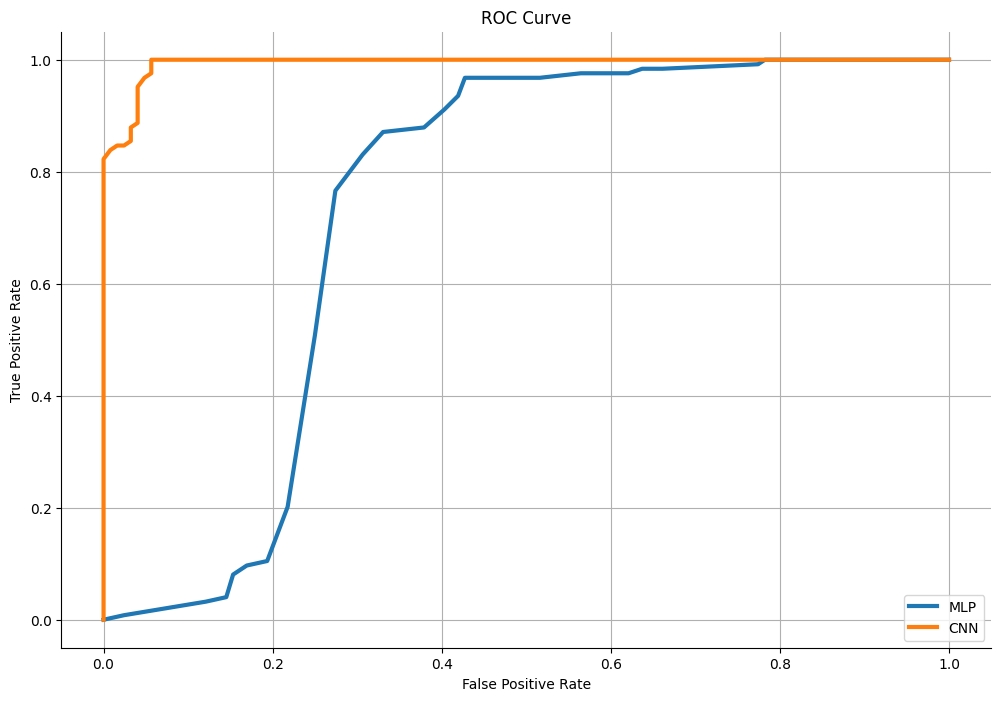

Площадь под ROC-кривой для MLP: 0.74
Площадь под ROC-кривой для CNN: 0.99


In [26]:
plt.figure(figsize=(12, 8))

predictions_mlp = model_mlp.predict(test_binary_images)
ROC_mlp = roc_from_scratch(predictions_mlp.reshape(-1), test_binary_labels, partitions=50)
plt.plot(ROC_mlp[:,0], ROC_mlp[:,1], label='MLP', linewidth=3)

predictions_cnn = model_cnn.predict(test_binary_images)
ROC_cnn = roc_from_scratch(predictions_cnn.reshape(-1), test_binary_labels, partitions=50)
plt.plot(ROC_cnn[:,0], ROC_cnn[:,1], label='CNN', linewidth=3)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

auc_score_mlp = np.trapz(sorted(ROC_mlp[:,1]), sorted(ROC_mlp[:,0]))
auc_score_cnn = np.trapz(sorted(ROC_cnn[:,1]), sorted(ROC_cnn[:,0]))

print(f'Площадь под ROC-кривой для MLP: {auc_score_mlp:.2f}')
print(f'Площадь под ROC-кривой для CNN: {auc_score_cnn:.2f}')

7. Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании).

In [6]:
df_train['label'].unique(), df_test['label'].unique()

(array([2, 0, 1]), array([2, 1, 0]))

Метки класса соовтетсвуют требованиям варианта.

In [7]:
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape

((2520,), (372,))

In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
train_labels = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels = encoder.transform(test_labels.reshape(-1, 1))
train_labels.shape, test_labels.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((2520, 3), (372, 3))

In [9]:
train_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [10]:
train_images = np.zeros(shape=(df_train.shape[0],300,300,3), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],300,300,3), dtype=np.float32)
train_images.shape, test_images.shape

((2520, 300, 300, 3), (372, 300, 300, 3))

In [11]:
for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train.iloc[idx]['image']))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test.iloc[idx]['image']))

train_images.shape, test_images.shape

((2520, 300, 300, 3), (372, 300, 300, 3))

In [12]:
train_images /= 255
test_images  /= 255

train_images.shape, test_images.shape

((2520, 300, 300, 3), (372, 300, 300, 3))

Обучим нейронную сеть MLP по задаче многоклассовой классификации изображений:

In [13]:
model_mlp_multi = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(300, 300, 3)),
    tf.keras.layers.Dense(60, activation='selu'),
    tf.keras.layers.Dense(80, activation='selu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(60, activation='selu'),
    tf.keras.layers.Dense(80, activation='selu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_mlp_multi.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adafactor(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_mlp_multi = model_mlp_multi.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(test_images, test_labels)
)

Epoch 1/10
20/20 [==============================] - 23s 1s/step - loss: 11.2877 - accuracy: 0.6108 - val_loss: 11.1693 - val_accuracy: 0.5744
Epoch 2/10
20/20 [==============================] - 17s 818ms/step - loss: 10.9562 - accuracy: 0.6733 - val_loss: 10.9550 - val_accuracy: 0.6201
Epoch 3/10
20/20 [==============================] - 15s 770ms/step - loss: 10.8341 - accuracy: 0.6938 - val_loss: 11.0939 - val_accuracy: 0.5905
Epoch 4/10
20/20 [==============================] - 16s 800ms/step - loss: 10.6854 - accuracy: 0.7054 - val_loss: 10.7742 - val_accuracy: 0.6362
Epoch 5/10
20/20 [==============================] - 17s 852ms/step - loss: 10.5497 - accuracy: 0.7218 - val_loss: 10.7699 - val_accuracy: 0.5941
Epoch 6/10
20/20 [==============================] - 15s 756ms/step - loss: 10.4243 - accuracy: 0.7358 - val_loss: 10.6537 - val_accuracy: 0.6461
Epoch 7/10
20/20 [==============================] - 15s 748ms/step - loss: 10.3061 - accuracy: 0.7475 - val_loss: 10.7089 - val_accur

Обучим нейронную сеть CNN по задаче многоклассовой классификации изображений:

In [13]:
model_cnn_multi = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_cnn_multi.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=['accuracy']
)

history_cnn_multi = model_cnn_multi.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(test_images, test_labels)
)


Epoch 1/10
20/20 [==============================] - 278s 13s/step - loss: 1.4246 - accuracy: 0.4286 - val_loss: 1.0621 - val_accuracy: 0.4543
Epoch 2/10
20/20 [==============================] - 241s 12s/step - loss: 0.8164 - accuracy: 0.6766 - val_loss: 0.9702 - val_accuracy: 0.5457
Epoch 3/10
20/20 [==============================] - 242s 12s/step - loss: 0.6146 - accuracy: 0.8028 - val_loss: 0.8119 - val_accuracy: 0.6774
Epoch 4/10
20/20 [==============================] - 248s 12s/step - loss: 0.4378 - accuracy: 0.8885 - val_loss: 0.6894 - val_accuracy: 0.7124
Epoch 5/10
20/20 [==============================] - 246s 12s/step - loss: 0.2997 - accuracy: 0.9282 - val_loss: 0.6751 - val_accuracy: 0.6747
Epoch 6/10
20/20 [==============================] - 244s 12s/step - loss: 0.2035 - accuracy: 0.9591 - val_loss: 0.6094 - val_accuracy: 0.7446
Epoch 7/10
20/20 [==============================] - 244s 12s/step - loss: 0.1485 - accuracy: 0.9710 - val_loss: 0.7198 - val_accuracy: 0.7016
Epoch 

8. Сравните качество многоклассовой классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

In [14]:
from sklearn.metrics import recall_score

predictions_mlp_multi = model_mlp_multi.predict(test_images)
predictions_mlp_multi = np.argmax(predictions_mlp_multi, axis=1)

test_labels = np.argmax(test_labels, axis=1)
recall_mlp = recall_score(test_labels, predictions_mlp_multi, average=None)
min_recall_mlp = np.min(recall_mlp)

print("Минимальная полнота классов для MLP модели:", min_recall_mlp)

12/12 [==============================] - 2s 110ms/step
Минимальная полнота классов для MLP модели: 0.3870967741935484


In [14]:
from sklearn.metrics import recall_score

predictions_cnn_multi = model_cnn_multi.predict(test_images)
predictions_cnn_multi = np.argmax(predictions_cnn_multi, axis=1)

test_labels = np.argmax(test_labels, axis=1)
recall_cnn = recall_score(test_labels, predictions_cnn_multi, average=None)
min_recall_cnn = np.min(recall_cnn)

print("Минимальная полнота классов для CNN модели:", min_recall_cnn)

12/12 [==============================] - 9s 779ms/step
Минимальная полнота классов для CNN модели: 0.6048387096774194


9. Постройте кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

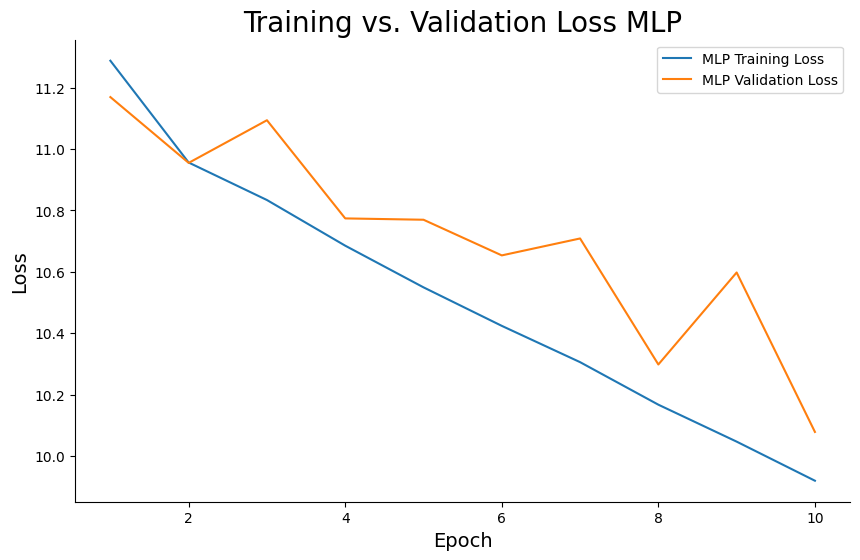

In [15]:
plot_training_loss(history_mlp_multi, 10, "MLP")

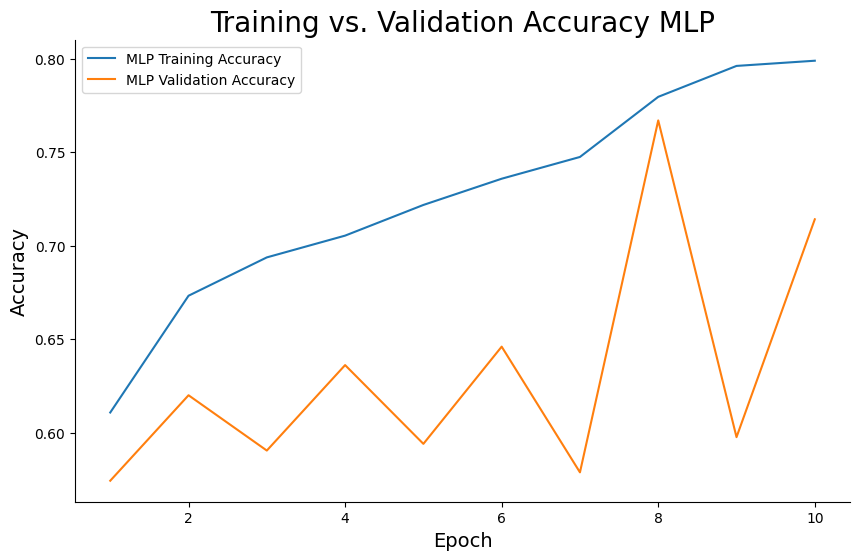

In [16]:
plot_training_accuracy(history_mlp_multi, 10, "MLP")

По графикам можно сказать, что сеть недообучилась.

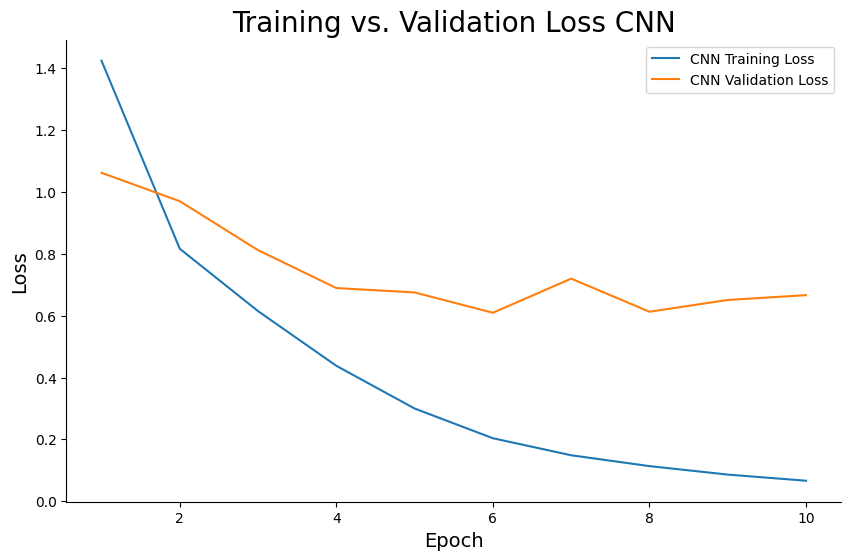

In [15]:
plot_training_loss(history_cnn_multi, 10, "CNN")

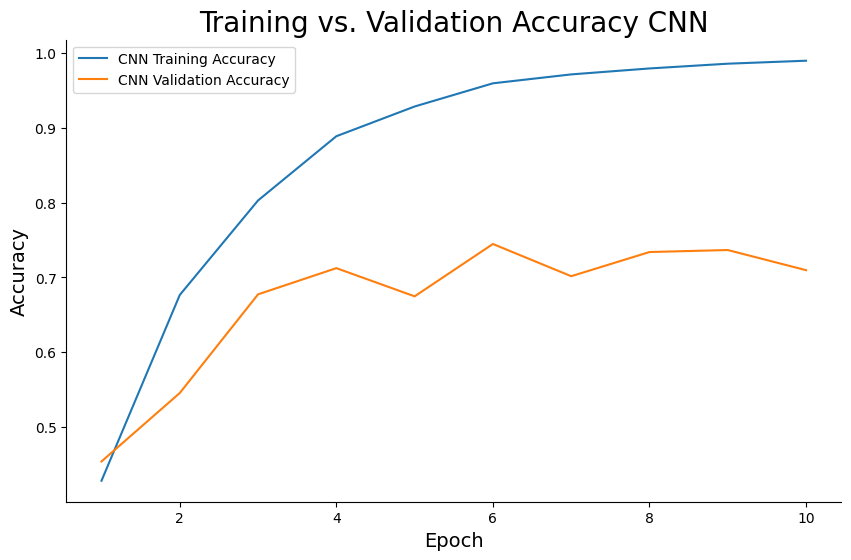

In [16]:
plot_training_accuracy(history_cnn_multi, 10, "CNN")

По графикам можно сказать, что сеть недообучилась.